In [1]:
%load_ext autoreload
%autoreload 2

from rl4co.envs.routing import PDPEnv, PDPGenerator, TSPEnv, TSPGenerator
import torch
from rl4co.utils.ops import gather_by_index
import matplotlib.pyplot as plt

/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/lightning/fabric/__init__.py:40: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/pkg_resources/__init__.py:2350: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:24: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _PYTHON_

In [2]:
# Single feat: generate a distribution of single-featured environments
generator = PDPGenerator(num_loc=50)
env = PDPEnv(generator=generator)

td_data = env.generator(8)

We can change the preset to generate some specific variant, for instance the VRPB

In [3]:
# Simple heuristics (nearest neighbor + capacity check)
def greedy_policy(td):
    """Select closest available action"""
    available_actions = td["action_mask"]
    # distances
    curr_node = td["current_node"]
    loc_cur = gather_by_index(td["locs"], curr_node)
    distances_next = torch.cdist(loc_cur[:, None, :], td["locs"], p=2.0).squeeze(1)
    distances_next[~available_actions.bool()] = float("inf")

    # # if sum of available actions is 0, select depot
    # distances_next[available_actions.sum(-1) == 0, 0] = 0
    action = torch.argmin(distances_next, dim=-1)
    td.set("action", action)
    return td


def rollout(env, td, policy=greedy_policy, max_steps: int = None):
    """Helper function to rollout a policy. Currently, TorchRL does not allow to step
    over envs when done with `env.rollout()`. We need this because for environments that complete at different steps.
    """

    max_steps = float("inf") if max_steps is None else max_steps
    actions = []
    steps = 0

    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
        steps += 1
        if steps > max_steps:
            print("Max steps reached")
            break
    return torch.stack(actions, dim=1)

### Solving with LKH

Note: to use LKH, you need to:

1. Download [here](http://webhotel4.ruc.dk/~keld/research/LKH-3/)
2. Unzip and compile it with `make`
3. Pass the solver path to the `solve` function

In [4]:
td_data = env.generator(8)
td = env.reset(td_data)

lkh_actions, lkh_costs = env.solve(td, solver="lkh", num_procs=8, max_runtime=1, solver_loc="../../../LKH-3.0.10/LKH")

/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/lightning_utilities/core/imports.py:13: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/lightning_utilities/core/imports.py:13: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: De

Cost (greedy): -7.868284702301025 | Cost (LKH): -6.959641456604004


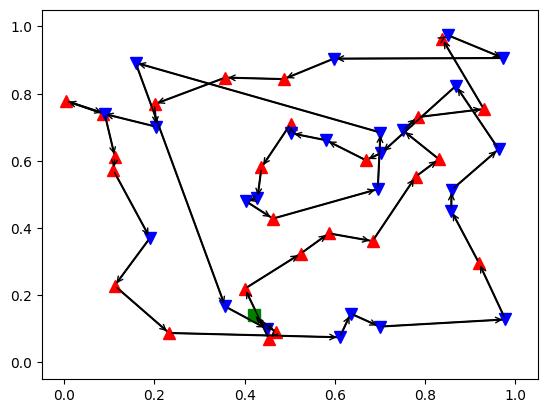

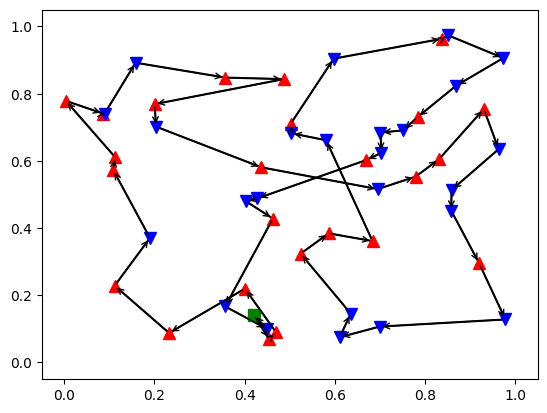

Cost (greedy): -9.655240058898926 | Cost (LKH): -7.996878623962402


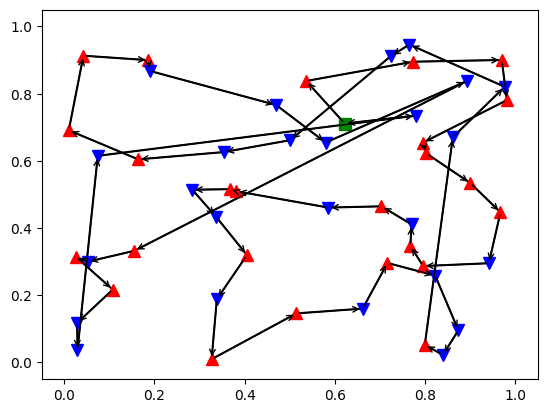

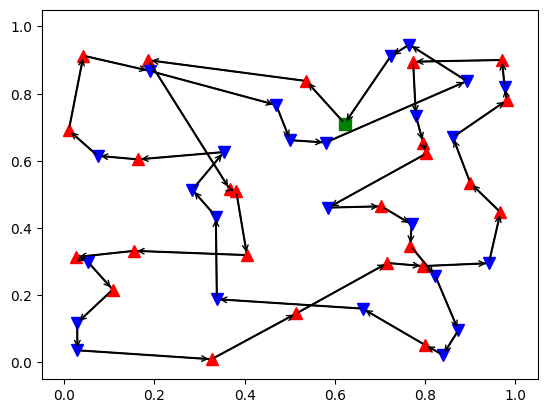

Cost (greedy): -10.018444061279297 | Cost (LKH): -7.482095718383789


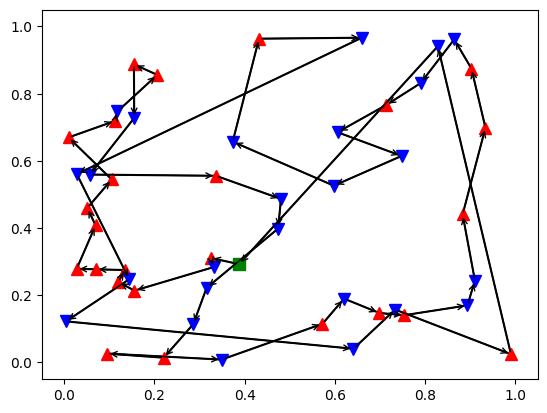

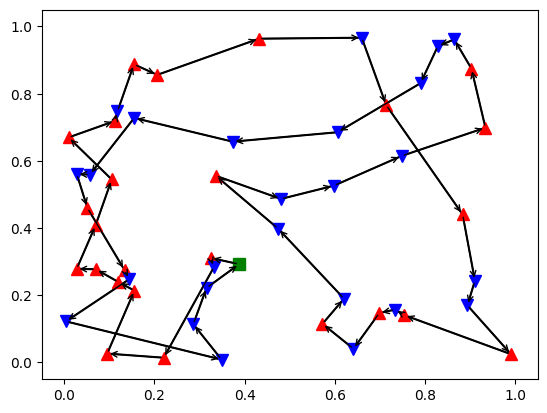

In [5]:
actions = rollout(env, td.clone(), greedy_policy)
rewards = env.get_reward(td, actions)
rewards_lkh = env.get_reward(td, lkh_actions)

for idx in [0, 1, 2]:
    env.render(td[idx], actions[idx])
    env.render(td[idx], lkh_actions[idx])
    print(f"Cost (greedy): {rewards[idx].item()} | Cost (LKH): {rewards_lkh[idx].item()}")
    plt.show()

### TSP

In [6]:
# Single feat: generate a distribution of single-featured environments
generator = TSPGenerator(num_loc=50)
env = TSPEnv(generator=generator)

td_data = env.generator(8)
td = env.reset(td_data)

lkh_actions, lkh_costs = env.solve(td, solver="lkh", num_procs=8, max_runtime=1, solver_loc="../../../LKH-3.0.10/LKH")

/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/lightning_utilities/core/imports.py:13: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/lightning_utilities/core/imports.py:13: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/botu/anaconda3/envs/rl4co/lib/python3.10/site-packages/pkg_resources/__init__.py:2871: De

Cost (greedy): -7.203794479370117 | Cost (LKH): -5.657799243927002


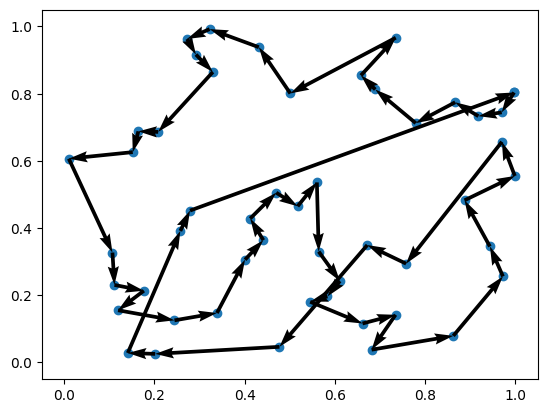

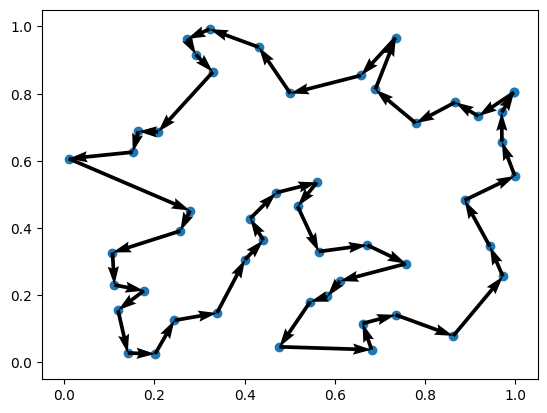

Cost (greedy): -6.799111843109131 | Cost (LKH): -5.508835315704346


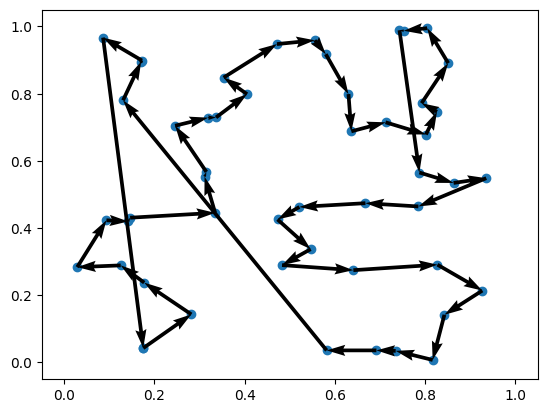

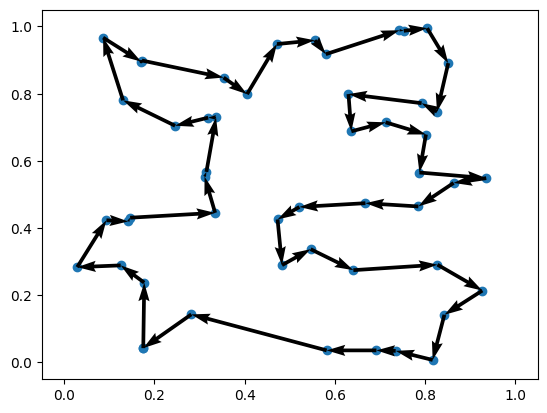

Cost (greedy): -6.739559650421143 | Cost (LKH): -5.613152980804443


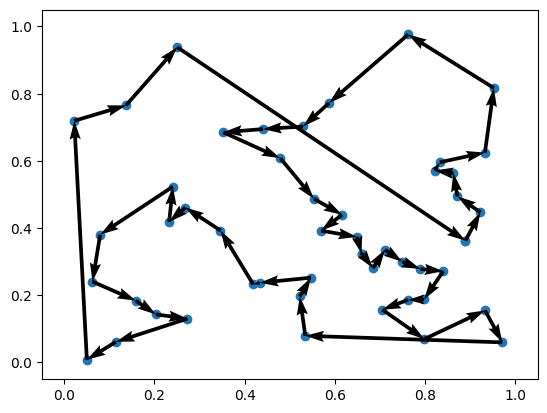

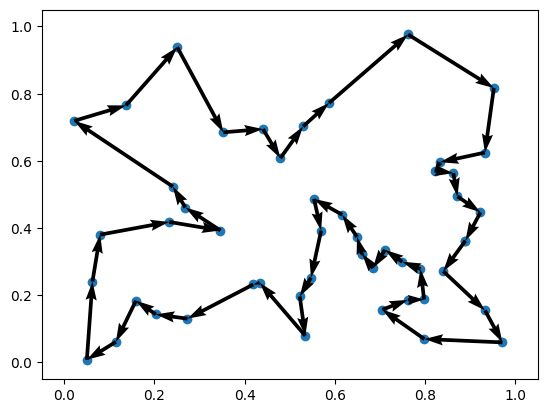

In [7]:
actions = rollout(env, td.clone(), greedy_policy)
rewards = env.get_reward(td, actions)
rewards_lkh = env.get_reward(td, lkh_actions)

for idx in [0, 1, 2]:
    env.render(td[idx], actions[idx])
    env.render(td[idx], lkh_actions[idx])
    print(f"Cost (greedy): {rewards[idx].item()} | Cost (LKH): {rewards_lkh[idx].item()}")
    plt.show()